# Nonlinear Langevin with Double-Welled Potential (Developement)

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [1]:
using PyPlot


include("DataGen.jl") # This has many packages in it's preamble
include("../../Tools/Model_Reduction_Dev.jl")

vector_wiener_filter_fft

In [2]:
steps = 10^6 + 1
scheme = "FE"
t_start = 0
t_stop = 10^3
discard = 100000
sig_init = [1.5]
sigma = [.3]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
e = randn(d,steps + discard)


Y = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d, e
    )

T = range(t_start,stop = t_stop, length = steps)

0.0:0.001:1000.0

In [3]:
Psi(x) = [x; x.^3]

Psi (generic function with 1 method)

In [3]:
# h_wf, pred = get_wf(Y,Psi, Preds = true);

Number of CKMS iterations: 1021
errK errR : 9.125935920826915e-11 5.77519236003518e-13


## Here we dive in to the sorce code to find the bug

### `get_wf'

In [1]:
# get_wf(Y,Psi, Preds = true);

In [4]:
# get_wf(
signal = Y  # Vector valued process
Psi; # column vector valued function
M_out = 20
n = 3 
p = 1500
par = 1500
rl = true
Preds = false
PI = false
rtol = 1e-6
# )

1.0e-6

In [5]:
# We would like a presample since we want the
# times series to be offset by one.

sig = signal[:,2:end] # sig is now one a head of signal
d, steps = size(sig)
nu = size(Psi(zeros(d,1)),1)

pred = complex(zeros(nu, steps))
for n = 1:steps
    pred[:,n] = Psi(signal[:,n])
end # pred is now even with signal and therefore one step
    # step behind sig. I.e. pred[:,n] = Psi(sig[:,n-1])
    # which is what we want so as to ensure the reduced
    # model can run explicitly.

In [6]:
# h_wf = vector_wiener_filter_fft(sig, pred, M_out,
#         n = n, p = p, par = par, PI = PI, rtol = rtol)

### `vector_wiener_filter_fft` 

In [7]:
# vector_wiener_filter_fft(
sig
pred
M_out
par
win = "Par"
n
p
PI
rtol
# )

1.0e-6

In [ ]:
d, stepsy = size(sig)
nu, stepsx = size(pred)

stepsx == stepsy || print("X and Y are not the same length. Taking min.")
steps = minimum([stepsx stepsy])
nfft = nextfastfft(steps)
nffth = Int(floor(nfft/2))
L = 55 #par

R_pred_smoothed = matrix_autocov_seq(pred,
   L = L,
   steps = steps,
   nu = nu,
   win = win
   )

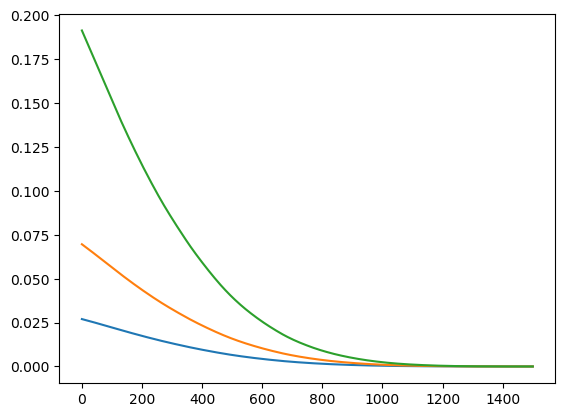

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000049ACB048>
 PyObject <matplotlib.lines.Line2D object at 0x000000004AC05488>
 PyObject <matplotlib.lines.Line2D object at 0x000000004AC05648>

In [9]:
### Break in

plot(real([R_pred_smoothed[1,1,
                :] R_pred_smoothed[1,2,
                :] R_pred_smoothed[2,2,:]]))

In [10]:
# Compute coefficients of spectral factorization of z-spect-pred
l = PI ? spectfact_matrix_CKMS_pinv(R_pred_smoothed,rtol = rtol) :
         spectfact_matrix_CKMS(R_pred_smoothed)

l_pad_minus = nfft >= L+1 ? cat(dims = 3,l,zeros(nu,nu,nfft - L - 1)) :
                           l[:,:,1:nfft]

z_spect_pred_minus_num_fft = fft(l_pad_minus,3)
z_spect_pred_plus_num_fft = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_plus_num_fft[:,:,i] = z_spect_pred_minus_num_fft[:,:,i]'
end

Number of CKMS iterations: 1048
errK errR : 6.979148928940532e-11 8.496088001283944e-14


In [23]:
### Break in
#recovered spectral density of pred
z_spect_pred_recoverd = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_recoverd[:,:,i] =z_spect_pred_minus_num_fft[:,:,i]'*
                                  z_spect_pred_plus_num_fft[:,:,i]
                            
end

z_spect_pred = z_crossspect_fft(pred, pred,
                    nfft = nfft, n = n, p = p, win = "Par");

In [18]:
z_spect_pred_recoverd

2×2 Array{Complex{Float64},2}:
  909.705-6.93273im   1174.25-8.449im
 -31.1905+0.475934im  11.0301+0.400685im

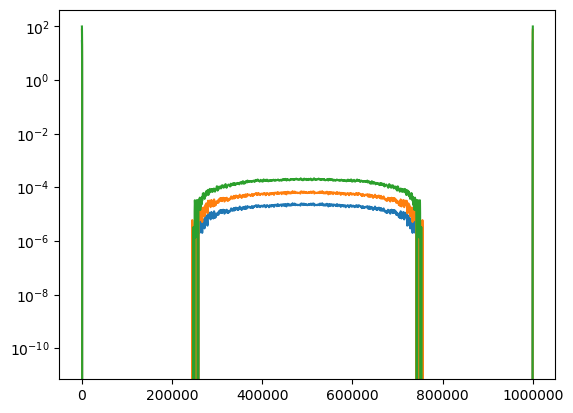

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002654E08>
 PyObject <matplotlib.lines.Line2D object at 0x0000000044C174C8>
 PyObject <matplotlib.lines.Line2D object at 0x0000000044C17108>

In [24]:
semilogy(real([z_spect_pred_recoverd[1,1,
                :] z_spect_pred_recoverd[1,2,
                :] z_spect_pred_recoverd[2,2,:]]))
# axis([0,2000,-20,100])

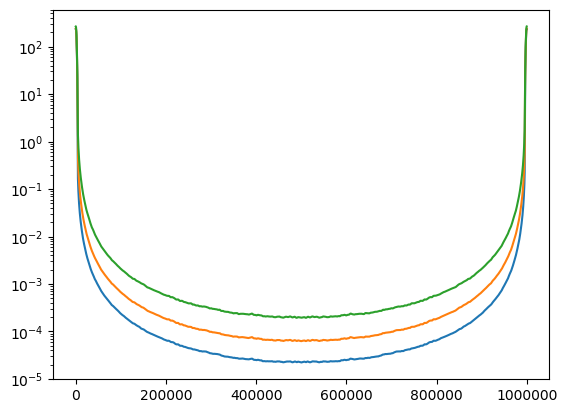

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000026F1788>
 PyObject <matplotlib.lines.Line2D object at 0x0000000044C69808>
 PyObject <matplotlib.lines.Line2D object at 0x0000000044C699C8>

In [21]:
semilogy(real([z_spect_pred[1,1,
                :] z_spect_pred[1,2,
                :] z_spect_pred[2,2,:]]))
# axis([0,2000,-20,300])

In [ ]:
# Compute z-cross-spectrum of sigpred
z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred,
                    nfft = nfft, n = n, p = p, win = "Par");

# This computes the impule response (coefficeints of z) for S_{yx}{S_x^+}^{-1}
S_sigpred_overS_plus_fft_num = complex(zeros(d,nu,nfft))

for i = 1 : nfft
    S_sigpred_overS_plus_fft_num[:,:,i] = z_crossspect_sigpred_num_fft[:,:,i]/
                                          z_spect_pred_plus_num_fft[:,:,i]
end

S_sigpred_overS_plus_fft_num_fft = ifft(S_sigpred_overS_plus_fft_num,3)

# Extracts causal part coefficinets of S_{yx}{S_x^+}^{-1}, {S_{yx}{S_x^+}^{-1}}_+
S_sigpred_overS_plus_fft_plus_num_fft = cat(dims = 3,
                S_sigpred_overS_plus_fft_num_fft[:,:,1: nffth],
                zeros(d,nu,nfft - nffth))

# Computes causal part of S_{yx}/S_x^+, {S_{yx}/S_x^+}_+
S_sigpred_overS_plus_plus_num_fft = fft(S_sigpred_overS_plus_fft_plus_num_fft,3);

# Obtain transfer function H by dividing {S_{yx}/S_x^+}_+ by S_x^-

H_num = complex(zeros(d,nu,nfft))
for i = 1: nfft
    H_num[:,:,i] = S_sigpred_overS_plus_plus_num_fft[:,:,i]/
                   z_spect_pred_minus_num_fft[:,:,i]
end

# Extrct tranferfunction coeffifcients (impulse responce of Weiner filter)
h_num_raw = ifft(H_num, 3)

# Truncate
M_out > nfft && println("M_out > nfft, taking min")
M = min(M_out, nfft)
h_num_fft = h_num_raw[:,:,1:M]

In [ ]:
h_wf = rl ? real(h_wf) : h_wf
Preds ? [h_wf, pred] : h_wf

In [4]:
Δt = (t_stop - t_start)/(steps - 1)
h_ana = zeros(1,2,10)
h_ana[:,:,1] = [1+Δt -Δt]

1×2 Array{Float64,2}:
 1.001  -0.001

### Get `Y_hat` the One-Step Predictions

In [5]:
M_h = size(h_ana,3)

Y_hat = zeros(size(Y)); 
Y_hat[:,1:M_h] = Y[:,1:M_h]
for i=M_h:steps-1
    Y_hat[:,i] = sum(h_ana[:,:,k+1]*pred[:,i-k]
                    for k = 0:M_h-1)
end

In [7]:
err = Y - Y_hat

Lags = -100:10
C1 = my_crosscov(pred[1,:],err[:],Lags)
C2 = my_crosscov(pred[2,:],err[:],Lags)


111-element Array{Complex,1}:
 0.00010082107980577497 + 0.0im
  0.0001010241333077838 + 0.0im
  0.0001012275778214079 + 0.0im
 0.00010143145061237064 + 0.0im
 0.00010163662858327693 + 0.0im
  0.0001018431736264247 + 0.0im
 0.00010205083259621735 + 0.0im
 0.00010225928512282375 + 0.0im
  0.0001024689132575123 + 0.0im
 0.00010267861973464625 + 0.0im
   0.000102889136503843 + 0.0im
 0.00010309984359956733 + 0.0im
 0.00010331072475565378 + 0.0im
                        ⋮
  0.0001242887499949173 + 0.0im
 0.00012456001494777946 + 0.0im
 0.00012428852642394145 + 0.0im
 0.00012401818823131518 + 0.0im
 0.00012374754471645703 + 0.0im
  0.0001234774374523211 + 0.0im
 0.00012320774393827179 + 0.0im
 0.00012293917617875005 + 0.0im
 0.00012267064657969583 + 0.0im
  0.0001224029078254196 + 0.0im
 0.00012213597758312014 + 0.0im
 0.00012187037287046833 + 0.0im

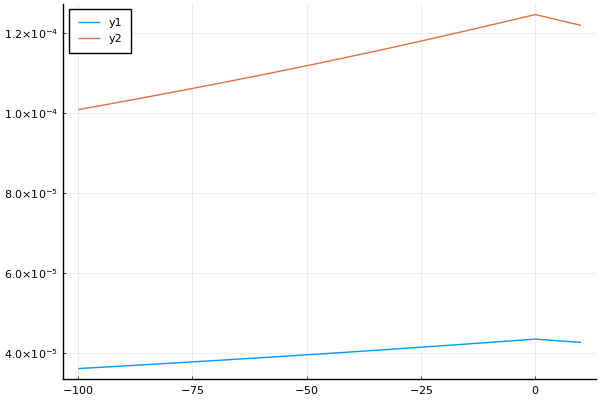

In [10]:
plot(Lags,real([C1 C2]))